In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [1]:
# Import jax.numpy and any other library we might need.
import jax.numpy as jnp
import numpyro

c:\Users\migue\Documents\tst_lightweight\.venv\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\migue\Documents\tst_lightweight\.venv\Lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\migue\Documents\tst_lightweight\.venv\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\Users\migue\Documents\tst_lightweight\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import preprocessing
from lightweight_mmm import utils
from lightweight_mmm import plot

In [3]:
# Let's assume we have the following datasets with the following shapes (we use
# the `simulate_dummy_data` function in utils for this example):
media_data, extra_features, target, costs = utils.simulate_dummy_data(
    data_size=160,
    n_media_channels=3,
    n_extra_features=2,
    geos=5) # Or geos=1 for national model

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


# ADSTOCK

In [48]:
probe = media_data[:,1,0]
probe.shape

(160,)

In [49]:
from lightweight_mmm.media_transforms import adstock, hill, carryover

In [50]:
df = pd.DataFrame({'media': probe, 
                   'ad_media_90': adstock(probe, lag_weight=0.9), 
                   'ad_media_70': adstock(probe, lag_weight=0.7), 
                   'ad_media_50': adstock(probe, lag_weight=0.5), 
                   'ad_media_30': adstock(probe, lag_weight=0.3), 
                   'ad_media_10': adstock(probe, lag_weight=0.1)}, 
                   index = range(160))
df

,media,ad_media_90,ad_media_70,ad_media_50,ad_media_30,ad_media_10
0,21.495794,2.149580,6.448739,10.747897,15.047055,19.346214
1,19.579594,3.892581,10.387995,15.163746,18.219831,19.556255
2,22.889912,5.792315,14.138569,19.026829,21.488888,22.556545
3,20.355442,7.248628,16.003632,19.691135,20.695477,20.575552
4,21.434008,8.667167,17.632744,20.562572,21.212448,21.348162
...,...,...,...,...,...,...
155,17.886747,19.319925,18.737143,18.338997,18.032274,17.866056
156,20.656704,19.453604,19.313011,19.497850,19.869373,20.377638
157,19.300411,19.438284,19.309229,19.399132,19.471100,19.408134
158,20.449039,19.539360,19.651173,19.924086,20.155657,20.344948


In [60]:
21.495794 * (1-.9)

2.1495793999999995

In [67]:
19.579594 * (1-.9) + 21.495794 * (1-.9)*0.9

3.892580859999999

In [69]:
22.889912*(1-0.9) + 19.579594 * (1-.9)*0.9 + 21.495794 * (1-.9)*0.9**2

5.792313973999999

<AxesSubplot: >

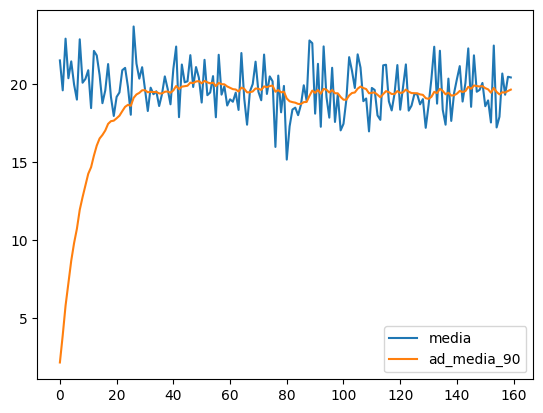

In [65]:
df.plot(y = ['media', 'ad_media_90'])

In [36]:
df_long = pd.melt(df.reset_index(), id_vars=['index'], var_name='variable', value_name='valor')
df_long

,index,variable,valor
0,0,media,21.495794
1,1,media,19.579594
2,2,media,22.889912
3,3,media,20.355442
4,4,media,21.434008
...,...,...,...
955,155,ad_media_10,17.866056
956,156,ad_media_10,20.377638
957,157,ad_media_10,19.408134
958,158,ad_media_10,20.344948


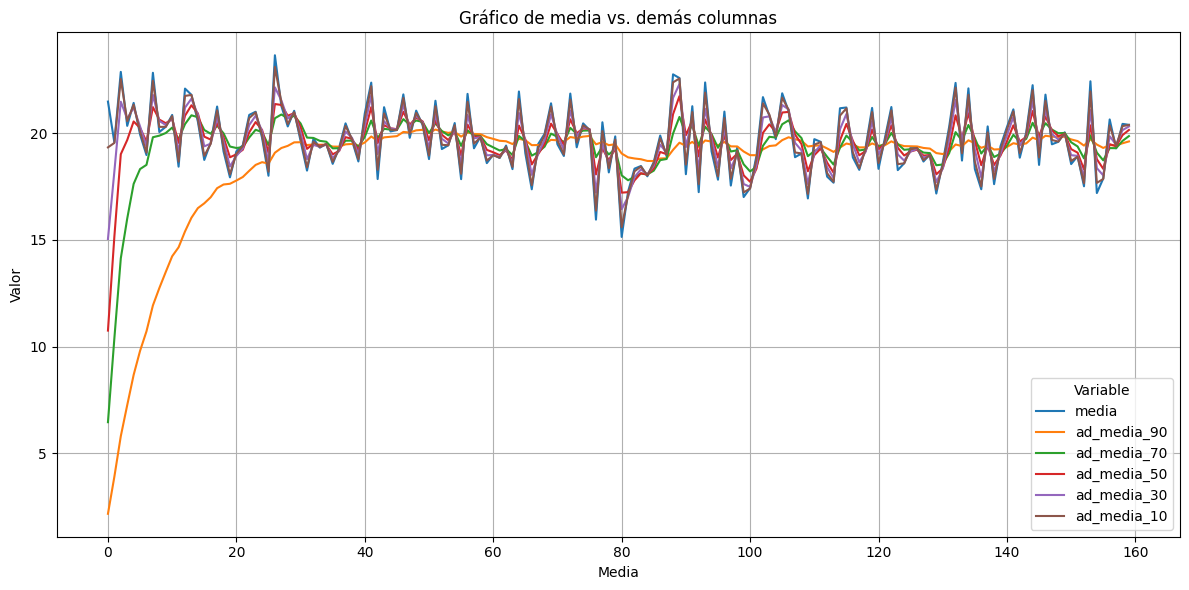

In [37]:

# Crear el gráfico
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_long, x='index',  y='valor', hue='variable')

plt.title('Gráfico de media vs. demás columnas')
plt.xlabel('Media')
plt.ylabel('Valor')
plt.legend(title='Variable')
plt.grid(True)
plt.tight_layout()
plt.show()


In [66]:
probe = np.zeros(160)
probe[0] = 100

df = pd.DataFrame({'media': probe, 
                   'ad_media_90': adstock(probe, lag_weight=0.9), 
                   'ad_media_70': adstock(probe, lag_weight=0.7), 
                   'ad_media_50': adstock(probe, lag_weight=0.5), 
                   'ad_media_30': adstock(probe, lag_weight=0.3), 
                   'ad_media_10': adstock(probe, lag_weight=0.1)}, 
                   index = range(160))
df

,media,ad_media_90,ad_media_70,ad_media_50,ad_media_30,ad_media_10
0,100.0,1.000000e+01,3.000000e+01,50.000,70.000000,89.999992
1,0.0,9.000002e+00,2.100000e+01,25.000,21.000000,9.000000
2,0.0,8.100001e+00,1.470000e+01,12.500,6.300001,0.900000
3,0.0,7.290001e+00,1.029000e+01,6.250,1.890000,0.090000
4,0.0,6.561001e+00,7.203000e+00,3.125,0.567000,0.009000
...,...,...,...,...,...,...
155,0.0,8.083273e-07,2.933028e-23,0.000,0.000000,0.000000
156,0.0,7.274945e-07,2.053119e-23,0.000,0.000000,0.000000
157,0.0,6.547451e-07,1.437184e-23,0.000,0.000000,0.000000
158,0.0,5.892705e-07,1.006028e-23,0.000,0.000000,0.000000


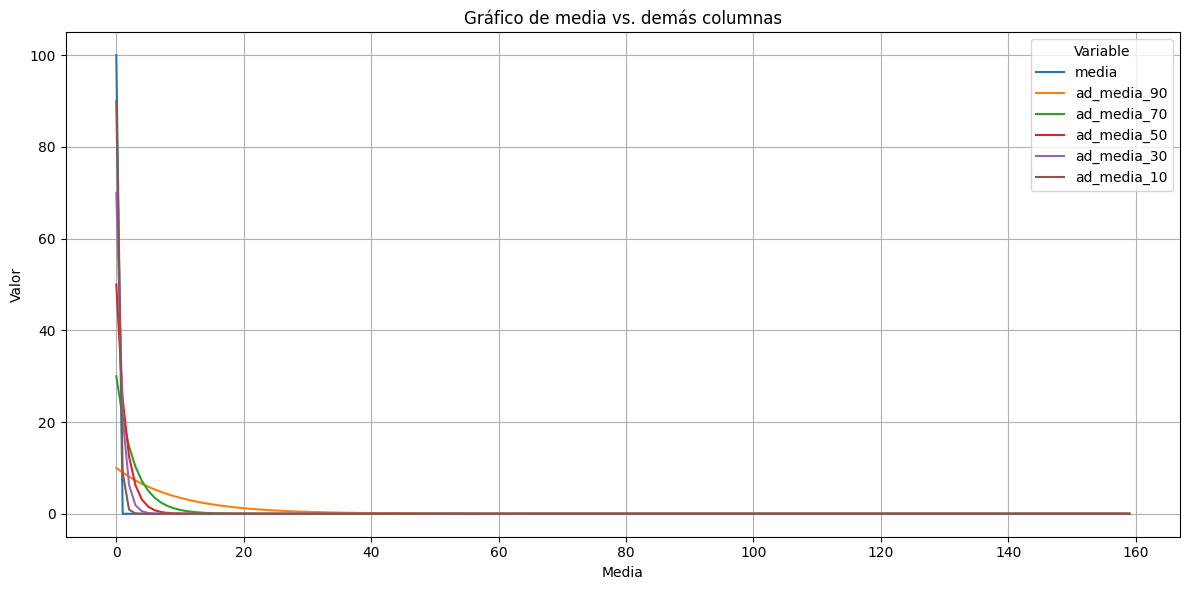

In [46]:
df_long = pd.melt(df.reset_index(), id_vars=['index'], var_name='variable', value_name='valor')

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_long, x='index',  y='valor', hue='variable')

plt.title('Gráfico de media vs. demás columnas')
plt.xlabel('Media')
plt.ylabel('Valor')
plt.legend(title='Variable')
plt.grid(True)
plt.tight_layout()
plt.show()

# CARRYOVER

In [82]:
media_data[:,1,0]

Array([21.495794, 19.579594, 22.889912, 20.355442, 21.434008, 19.953102,
       18.98568 , 22.847874, 20.067327, 20.311138, 20.86911 , 18.441547,
       22.105373, 21.813042, 20.562155, 18.75733 , 19.575558, 21.2627  ,
       19.15767 , 17.939917, 19.158676, 19.445602, 20.870554, 21.01851 ,
       19.80207 , 18.015764, 23.66986 , 21.294477, 20.329378, 21.062887,
       19.646769, 18.256035, 19.75094 , 19.332056, 19.519802, 18.573511,
       19.331623, 20.474056, 19.676943, 18.68547 , 20.943222, 22.384878,
       17.8608  , 21.233183, 20.094921, 20.159399, 21.832838, 19.794683,
       21.071085, 20.395683, 18.797834, 21.53443 , 19.268188, 19.44315 ,
       20.489374, 17.854053, 21.857576, 19.303257, 19.842518, 18.607168,
       19.003546, 18.848904, 19.431808, 18.324804, 21.969265, 19.067505,
       17.379194, 19.501356, 19.984352, 21.415806, 19.491634, 18.943144,
       21.871422, 19.349329, 20.471636, 20.15808 , 15.955279, 20.524055,
       18.172022, 19.861538, 15.143388, 17.27006 , 

In [90]:
import jax
jnp.array(0.1)

Array(0.1, dtype=float32, weak_type=True)

In [96]:
probe = media_data[:,1,0]

df = pd.DataFrame({'media': probe, 
                   'co_media_01': carryover(probe, ad_effect_retention_rate=jnp.array(0.1), peak_effect_delay =  jnp.array(1), number_lags = 13), 
                   'co_media_02': carryover(probe, ad_effect_retention_rate=jnp.array(0.2), peak_effect_delay =  jnp.array(1), number_lags = 13), 
                   'co_media_04': carryover(probe, ad_effect_retention_rate=jnp.array(0.4), peak_effect_delay =  jnp.array(1), number_lags = 13), 
                   'co_media_08': carryover(probe, ad_effect_retention_rate=jnp.array(0.8), peak_effect_delay =  jnp.array(1), number_lags = 13), 
                   'co_media_10': carryover(probe, ad_effect_retention_rate=jnp.array(1.0), peak_effect_delay =  jnp.array(1), number_lags = 13)}, 
                   index = range(160))

df_long = pd.melt(df.reset_index(), id_vars=['index'], var_name='variable', value_name='valor')

ValueError: vmap was requested to map its argument along axis 1, which implies that its rank should be at least 2, but is only 1 (its shape is (160,))